In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import seaborn as sns

2024-11-30 12:41:23.433987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 12:41:23.434020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 12:41:23.435508: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 12:41:23.443734: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_dir = '../Dataset_BUSI_with_GT'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Train,Val and Test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2421 images belonging to 3 classes.
Found 517 images belonging to 3 classes.
Found 522 images belonging to 3 classes.


In [3]:
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

2024-11-30 12:41:28.095547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31124 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


In [4]:
#Final layers set
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)

In [5]:
model = Model(inputs=base_model.input, outputs=output_layer)

In [6]:
#Freeze early layers
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


2024-11-30 12:42:21.454732: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2024-11-30 12:42:24.837550: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f40bd012e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-30 12:42:24.837599: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2024-11-30 12:42:24.852336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732970544.985161   10636 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 [==============================] - 88s 620ms/step - loss: 0.6849 - accuracy: 0.7278 - val_loss: 0.4791 - val_accuracy: 0.8182
Epoch 2/10
76/76 [==============================] - 35s 463ms/step - loss: 0.3728 - accuracy: 0.8542 - val_loss: 0.4120 - val_accuracy: 0.8356
Epoch 3/10
76/76 [==============================] - 36s 469ms/step - loss: 0.2679 - accuracy: 0.8963 - val_loss: 0.3124 - val_accuracy: 0.8878
Epoch 4/10
76/76 [==============================] - 35s 463ms/step - loss: 0.1868 - accuracy: 0.9343 - val_loss: 0.2618 - val_accuracy: 0.8994
Epoch 5/10
76/76 [==============================] - 36s 466ms/step - loss: 0.1150 - accuracy: 0.9665 - val_loss: 0.2381 - val_accuracy: 0.9246
Epoch 6/10
76/76 [==============================] - 36s 466ms/step - loss: 0.0877 - accuracy: 0.9785 - val_loss: 0.2823 - val_accuracy: 0.9052
Epoch 7/10
76/76 [==============================] - 35s 461ms/step - loss: 0.0680 - accuracy: 0.9839 - val_loss: 0.2288 - val_accuracy: 0.9188
Epoch 8/10

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

17/17 [==============================] - 7s 403ms/step - loss: 0.2387 - accuracy: 0.9310
Test accuracy: 0.931034505367279


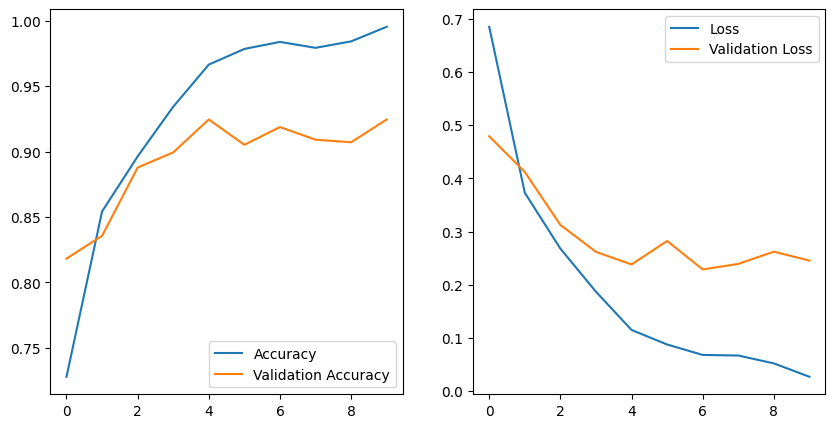

In [10]:
#Accuracy,Val accuracy, loss and val loss graphs
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [11]:
predictions = model.predict(test_generator)
class_predictions = predictions.argmax(axis=1)  # Get the class with the highest probability

# True labels from test generator
true_labels = test_generator.classes

17/17 [==============================] - 16s 369ms/step


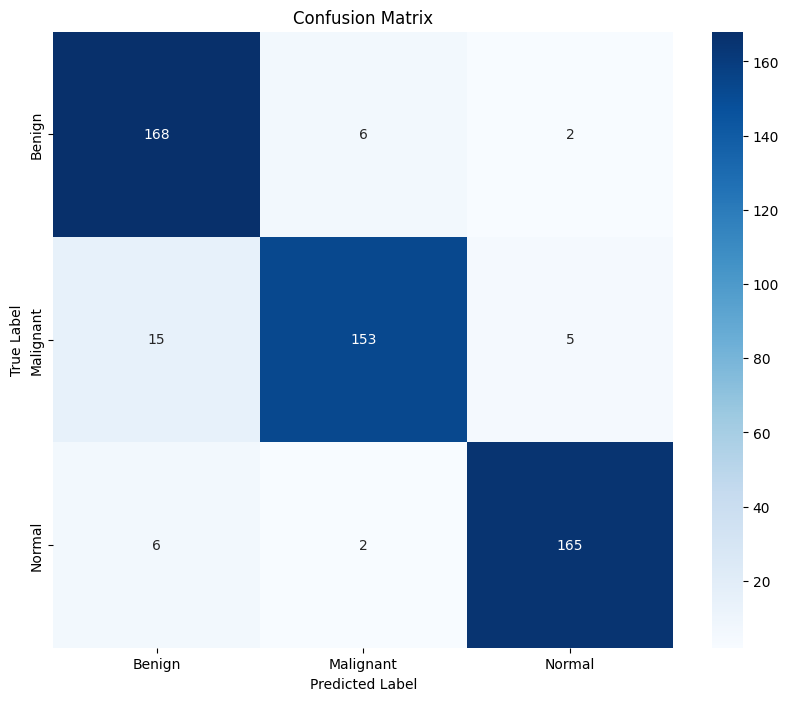

In [12]:
cm = confusion_matrix(true_labels, class_predictions)

class_labels = ['Benign', 'Malignant', 'Normal']

# Plot confusion matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
model.save('NASNet_3class_low')

INFO:tensorflow:Assets written to: NASNet_3class_low/assets


INFO:tensorflow:Assets written to: NASNet_3class_low/assets
